# 1.6 signac-flow minimal example

<div class="alert alert-warning">

Note: This example is in the process of being updated for the latest versions of signac and signac-flow.
    
    
</div>


## About

This notebook contains a minimal example for running a signac-flow project from scratch.
The example demonstrates how to compare an ideal gas with a Lennard-Jones fluid by calculating a p-V phase diagram.

## Author

Carl Simon Adorf

## Before you start

Make sure you installed signac and signac-flow, e.g., with:

```
conda install -c conda-forge signac signac-flow
```

In [1]:
import flow
import numpy as np
import signac

# Enter the signac project directory
project = signac.init_project(
    name="FlowTutorialProject", root="projects/tutorial-signac-flow"
)

We want to generate a pressure-volume (p-V) phase diagram for an ideal gas.

We define a function to calculate the result for a given state point:

In [2]:
def V_idg(N, p, kT):
    return N * kT / p

We want to use **signac** to manage our data, therefore we define an *operation* which has only the *signac job* as argument:

In [3]:
def compute_volume(job):
    job.document["V"] = V_idg(**job.statepoint())

For this demonstration we will specialize a `flow.FlowProject` to manage our simple *workflow*.

The workflow is controlled by two core functions: `label()` and `next_operation()`:
 - The `labels()` function allows us to *label* our jobs and get a good overview of the project *status*. This is especially important once the data space becomes larger and more complex and operations more expensive.
 - The `next_operation()` functions helps to automate the workflow by identifying the next required operation for each job.
 
 In this case there is only **one** operation:

In [4]:
class MyProject(flow.FlowProject):
    def labels(self, job):
        yield "init"
        if "V" in job.document:
            yield "estimated"

    def next_operation(self, job):
        labels = set(self.labels(job))
        if "V" not in job.document:
            return "compute_volume"

We need to use the `get_project()` *class method* to get a project handle for this special project class.

In [5]:
project = MyProject.get_project(root="projects/tutorial-signac-flow")

Now it's time to actually generate some data! Let's initialize the data space!


In [6]:
for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=1728, kT=1.0, p=p)
    job = project.open_job(sp)
    print(job.id)
    job.init()

a14ee3104f26974b22bb84f62500c84d
55d4d6ebbc04a1f8a259a2c5de197328
4b299db86ff480f92e520eac91112108
26e2f19b5b211edb80ebe60a5a62bd75
75c10d0fa7a4f4b4742ce5e9c119e8bd
46859989efcfd89653fa65db2375884b
f3f3c351f81acd2140edd239b9183af4
b38e30524c2c36e3ebfe50481eb91992
bb277ac022ce744d38f9e87c1fabe08c
6f9bc79d670e42d4a40041ce7be9cdaf


The `print_status()` function allows to get a quick overview of our project's *status*:

In [7]:
project.print_status(detailed=True);



Overview:

Total # of jobs: 10

label    ratio
-------  --------------------------------------------------
init     |████████████████████████████████████████| 100.00%

operation
-----------


Detailed View:

job id                            operation    labels
--------------------------------  -----------  --------
75c10d0fa7a4f4b4742ce5e9c119e8bd  [ ]          init
46859989efcfd89653fa65db2375884b  [ ]          init
a14ee3104f26974b22bb84f62500c84d  [ ]          init
f3f3c351f81acd2140edd239b9183af4  [ ]          init
55d4d6ebbc04a1f8a259a2c5de197328  [ ]          init
b38e30524c2c36e3ebfe50481eb91992  [ ]          init
bb277ac022ce744d38f9e87c1fabe08c  [ ]          init
4b299db86ff480f92e520eac91112108  [ ]          init
6f9bc79d670e42d4a40041ce7be9cdaf  [ ]          init
26e2f19b5b211edb80ebe60a5a62bd75  [ ]          init

[U]:unknown [R]:registered [I]:inactive [S]:submitted [H]:held [Q]:queued [A]:active [E]:error




The next cell will attempt to execute all operations by cycling through jobs and operations until no *next operations* are defined anymore.

We limit the max. number of cycles to prevent accidental infinite loops, the number of cycles is arbitrary.

In [8]:
for i in range(3):
    for job in project:
        for j in range(5):
            next_op = project.next_operation(job)
            if next_op is None:
                break
            print("execute", job, next_op)
            globals()[next_op](job)
            assert next_op != project.next_operation(job)
        else:
            raise RuntimeError("Reached max. # cycle limit!")

execute 46859989efcfd89653fa65db2375884b compute_volume
execute 4b299db86ff480f92e520eac91112108 compute_volume
execute bb277ac022ce744d38f9e87c1fabe08c compute_volume
execute 75c10d0fa7a4f4b4742ce5e9c119e8bd compute_volume
execute f3f3c351f81acd2140edd239b9183af4 compute_volume
execute 26e2f19b5b211edb80ebe60a5a62bd75 compute_volume
execute 6f9bc79d670e42d4a40041ce7be9cdaf compute_volume
execute a14ee3104f26974b22bb84f62500c84d compute_volume
execute b38e30524c2c36e3ebfe50481eb91992 compute_volume
execute 55d4d6ebbc04a1f8a259a2c5de197328 compute_volume


Let's double check the project status.

In [9]:
project.print_status();



Overview:

Total # of jobs: 10

label      ratio
---------  --------------------------------------------------
estimated  |████████████████████████████████████████| 100.00%
init       |████████████████████████████████████████| 100.00%

operation
-----------





After running all operations we can make a brief examination of the collected data.

In [10]:
for job in project:
    print(job.statepoint()["p"], job.document.get("V"))

3.0 576.0
1.5 1152.0
4.5 384.0
2.5 691.2
3.5 493.7142857142857
2.0 864.0
5.0 345.6
0.5 3456.0
4.0 432.0
1.0 1728.0


For a better presentation of the results we need to aggregate all results and sort them by pressure.

[3456.0, 1728.0, 1152.0, 864.0, 691.2, 576.0, 493.7142857142857, 432.0, 384.0, 345.6]


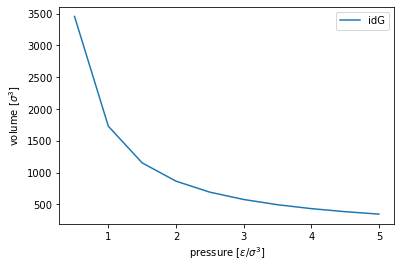

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt

V = {}

for job in project:
    V[job.statepoint()["p"]] = job.document["V"]

p = sorted(V.keys())
V = [V[p_] for p_ in p]
print(V)

plt.plot(p, V, label="idG")
plt.xlabel(r"pressure [$\epsilon / \sigma^3$]")
plt.ylabel(r"volume [$\sigma^3$]")
plt.legend()
plt.show()

As a a final step, we can generate a index of our project data.
You can store this index in a variable or within a database, e.g., for search operations.

In [12]:
for doc in project.index():
    print(doc)

{'_id': '46859989efcfd89653fa65db2375884b', 'statepoint': {'N': 1728, 'kT': 1.0, 'p': 3.0}, 'V': 576.0, 'signac_id': '46859989efcfd89653fa65db2375884b', 'root': 'notebooks/projects/tutorial-signac-flow/workspace'}
{'_id': '4b299db86ff480f92e520eac91112108', 'statepoint': {'N': 1728, 'kT': 1.0, 'p': 1.5}, 'V': 1152.0, 'signac_id': '4b299db86ff480f92e520eac91112108', 'root': 'notebooks/projects/tutorial-signac-flow/workspace'}
{'_id': 'bb277ac022ce744d38f9e87c1fabe08c', 'statepoint': {'N': 1728, 'kT': 1.0, 'p': 4.5}, 'V': 384.0, 'signac_id': 'bb277ac022ce744d38f9e87c1fabe08c', 'root': 'notebooks/projects/tutorial-signac-flow/workspace'}
{'_id': '75c10d0fa7a4f4b4742ce5e9c119e8bd', 'statepoint': {'N': 1728, 'kT': 1.0, 'p': 2.5}, 'V': 691.2, 'signac_id': '75c10d0fa7a4f4b4742ce5e9c119e8bd', 'root': 'notebooks/projects/tutorial-signac-flow/workspace'}
{'_id': 'f3f3c351f81acd2140edd239b9183af4', 'statepoint': {'N': 1728, 'kT': 1.0, 'p': 3.5}, 'V': 493.7142857142857, 'signac_id': 'f3f3c351f81ac

Uncomment and execute the following line to remove all data and start over.

In [13]:
# %rm -r projects/tutorial-signac-flow/workspace